In [9]:
!pip install rasterstats


In [1]:
import os
import geopandas as gpd

shapefile_path = os.path.join("shape_file", "DISTRITOS.shp")
gdf = gpd.read_file(shapefile_path)
gdf.head()

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."


In [2]:
import rasterio

# Ruta al archivo
archivo = "tmin_raster.tif"

In [3]:

from rasterstats import zonal_stats


In [4]:
import numpy as np
import pandas as pd
import rasterio

# --- Parámetros ---
raster_path = archivo  # tu ráster
gdf = gdf.copy()                  # partimos del gdf ya cargado

# --- Métrica personalizada: coeficiente de variación (std/mean) ---
def cv(x):
    a = np.asarray(x, dtype="float64")
    a = a[~np.isnan(a)]
    if a.size == 0:
        return np.nan
    m = a.mean()
    return float(a.std() / m) if m != 0 else np.nan

# --- Asegurar CRS y conocer número de bandas ---
with rasterio.open(raster_path) as src:
    nband = src.count
    rcrs = src.crs
    nodata = src.nodata

# Reproyecta tus polígonos al CRS del ráster (importante para zonal_stats)
if gdf.crs != rcrs:
    gdf = gdf.to_crs(rcrs)

raster_path = archivo  # tu ráster
gdf = gdf.copy()                  # partimos del gdf ya cargado

# --- Métrica personalizada: coeficiente de variación (std/mean) ---
def cv(x):
    a = np.asarray(x, dtype="float64")
    a = a[~np.isnan(a)]
    if a.size == 0:
        return np.nan
    m = a.mean()
    return float(a.std() / m) if m != 0 else np.nan

# --- Asegurar CRS y conocer número de bandas ---
with rasterio.open(raster_path) as src:
    nband = src.count
    rcrs = src.crs
    nodata = src.nodata

# Reproyecta tus polígonos al CRS del ráster (importante para zonal_stats)
if gdf.crs != rcrs:
    gdf = gdf.to_crs(rcrs)

In [5]:
dfs = []
for b in range(1, nband + 1):
    zs = zonal_stats(
        gdf,
        raster_path,
        band=b,
        stats=["count", "mean", "min", "max", "std", "percentile_10", "percentile_90"],
        add_stats={"cv": cv},      # <-- métrica personalizada
        nodata=nodata,
        all_touched=False,
        geojson_out=False
    )
    dfb = pd.DataFrame(zs).add_prefix(f"tmin_banda{b}_")
    dfs.append(dfb)

stats_df = pd.concat(dfs, axis=1)
gdf = gdf.join(stats_df)

d:\anaconda3\Lib\site-packages\rasterstats\io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


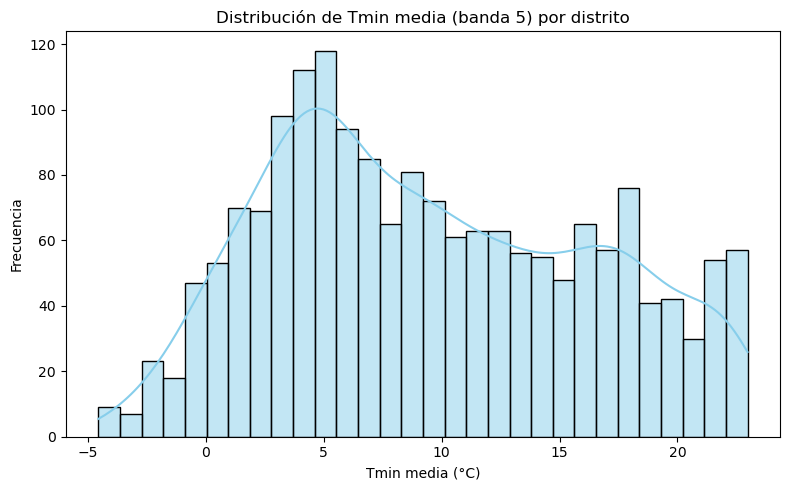

In [7]:
import seaborn as sns

import matplotlib.pyplot as plt

# --- Histograma/KDE de la media Tmin a nivel de distrito ---
plt.figure(figsize=(8, 5))
sns.histplot(gdf["tmin_banda5_mean"].dropna(), kde=True, bins=30, color='skyblue')
plt.title("Distribución de Tmin media (banda 5) por distrito")
plt.xlabel("Tmin media (°C)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [12]:
# --- Clasificación: 15 distritos con Tmin medio más bajo y más alto ---
top15_low = gdf.nsmallest(15, "tmin_banda5_mean")[["DISTRITO", "tmin_banda5_mean"]]
top15_high = gdf.nlargest(15, "tmin_banda5_mean")[["DISTRITO", "tmin_banda5_mean"]]

top15_low.to_csv("top15_tmin_baja_distritos.csv", index=False)
top15_high.to_csv("top15_tmin_alta_distritos.csv", index=False)


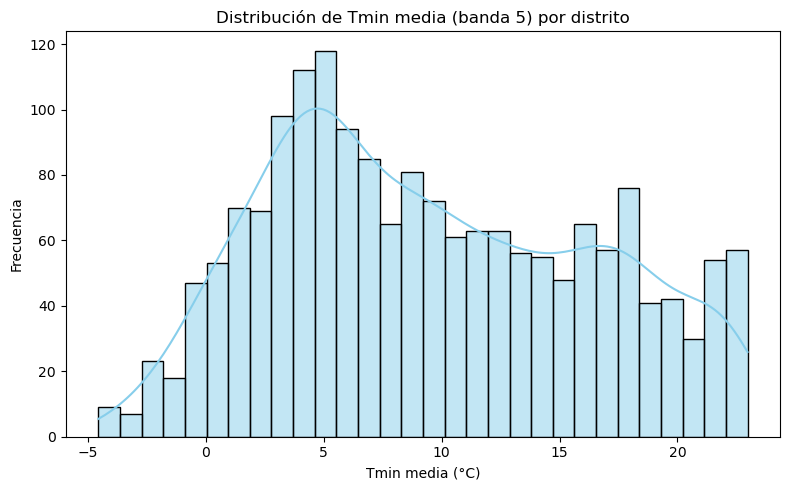

C:\Users\ALAN\AppData\Local\Temp\ipykernel_65028\3934881875.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

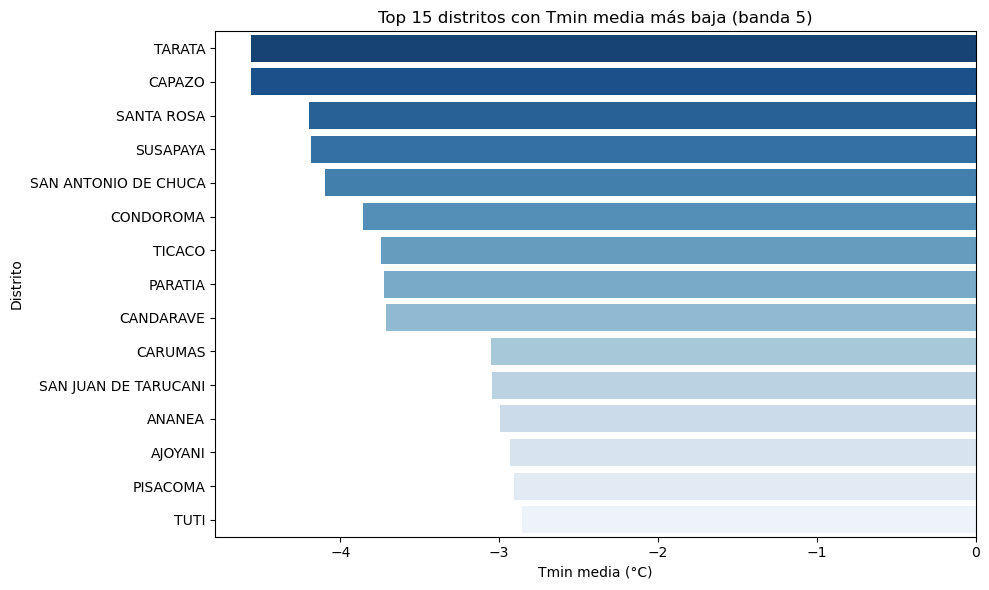

C:\Users\ALAN\AppData\Local\Temp\ipykernel_65028\3934881875.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

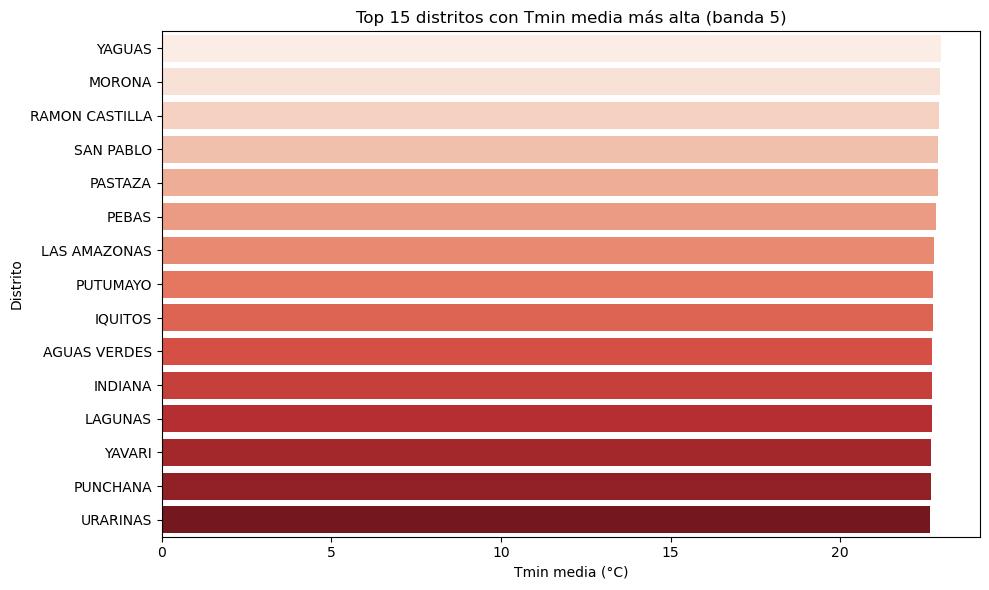

<Figure size 640x480 with 0 Axes>

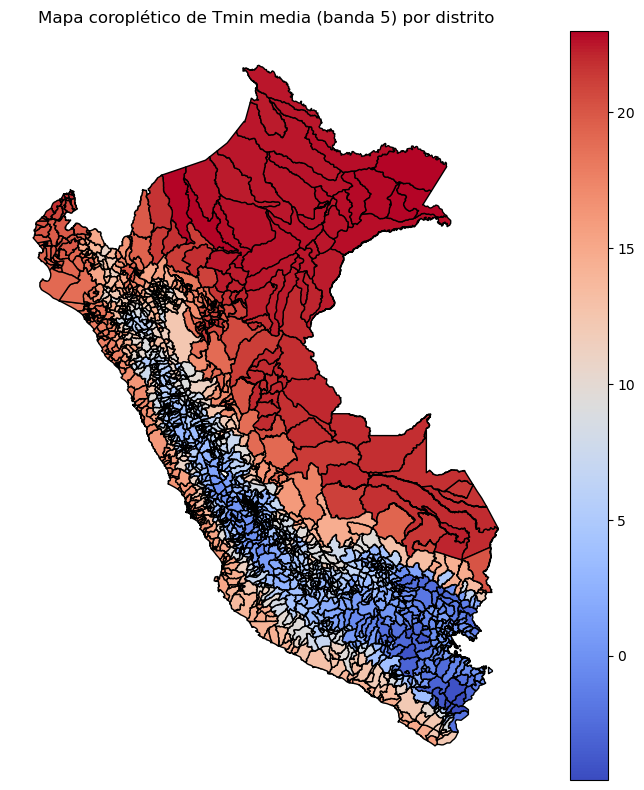

<Figure size 640x480 with 0 Axes>

In [11]:
# --- 1. Distribución de Tmin media (banda 5) ---
plt.figure(figsize=(8, 5))
sns.histplot(gdf["tmin_banda5_mean"].dropna(), kde=True, bins=30, color='skyblue')
plt.title("Distribución de Tmin media (banda 5) por distrito")
plt.xlabel("Tmin media (°C)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()
plt.savefig("hist_tmin_media.png", dpi=300)

# --- 2. Ranking: Top 15 distritos con Tmin media más baja ---
plt.figure(figsize=(10, 6))
sns.barplot(
    y=top15_low["DISTRITO"],
    x=top15_low["tmin_banda5_mean"],
    palette="Blues_r"
)
plt.title("Top 15 distritos con Tmin media más baja (banda 5)")
plt.xlabel("Tmin media (°C)")
plt.ylabel("Distrito")
plt.tight_layout()
plt.show()
plt.savefig("Top_15_distritos_bajos.png", dpi=300)

# --- 3. Ranking: Top 15 distritos con Tmin media más alta ---
plt.figure(figsize=(10, 6))
sns.barplot(
    y=top15_high["DISTRITO"],
    x=top15_high["tmin_banda5_mean"],
    palette="Reds"
)
plt.title("Top 15 distritos con Tmin media más alta (banda 5)")
plt.xlabel("Tmin media (°C)")
plt.ylabel("Distrito")
plt.tight_layout()
plt.show()
plt.savefig("Top_15_distritos_altos.png", dpi=300)

# --- 4. Mapa coroplético estático ---
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column="tmin_banda5_mean", cmap="coolwarm", legend=True, ax=ax, edgecolor='k')
ax.set_title("Mapa coroplético de Tmin media (banda 5) por distrito")
ax.axis('off')
plt.tight_layout()
plt.show()
plt.savefig("mapa_distritos_tmin_mean.png", dpi=300)

In [13]:
gdf.columns

Index(['IDDPTO', 'DEPARTAMEN', 'IDPROV', 'PROVINCIA', 'IDDIST', 'DISTRITO',
       'CAPITAL', 'CODCCPP', 'AREA', 'FUENTE', 'geometry', 'tmin_banda1_min',
       'tmin_banda1_max', 'tmin_banda1_mean', 'tmin_banda1_count',
       'tmin_banda1_std', 'tmin_banda1_percentile_10',
       'tmin_banda1_percentile_90', 'tmin_banda1_cv', 'tmin_banda2_min',
       'tmin_banda2_max', 'tmin_banda2_mean', 'tmin_banda2_count',
       'tmin_banda2_std', 'tmin_banda2_percentile_10',
       'tmin_banda2_percentile_90', 'tmin_banda2_cv', 'tmin_banda3_min',
       'tmin_banda3_max', 'tmin_banda3_mean', 'tmin_banda3_count',
       'tmin_banda3_std', 'tmin_banda3_percentile_10',
       'tmin_banda3_percentile_90', 'tmin_banda3_cv', 'tmin_banda4_min',
       'tmin_banda4_max', 'tmin_banda4_mean', 'tmin_banda4_count',
       'tmin_banda4_std', 'tmin_banda4_percentile_10',
       'tmin_banda4_percentile_90', 'tmin_banda4_cv', 'tmin_banda5_min',
       'tmin_banda5_max', 'tmin_banda5_mean', 'tmin_banda5_count',

# Políticas públicas
 

In [58]:
# === Imports ===
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pandas as pd
import numpy as np

sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# === Parámetros/umbrales (ajustables) ===
DEPTS_ALTOANDINOS = ["PUNO","CUSCO","AYACUCHO","HUANCAVELICA","PASCO","APURIMAC","AREQUIPA","JUNIN"]
DEPTS_AMAZONICOS  = ["LORETO","UCAYALI","MADRE DE DIOS"]

UMBRAL_HELADA_P10 = -2.0   # °C (percentil 10 de Tmin)
UMBRAL_HELADA_MEDIA = 0.0 # °C (opcional de referencia)
UMBRAL_FRIAJE_MEDIA = 22.0 # °C

# === Limpieza rápida de nombres de depto (por si vienen con minúsculas/espacios) ===
gdf["DEPARTAMEN"] = gdf["DEPARTAMEN"].str.upper().str.strip()
gdf["DISTRITO"]   = gdf["DISTRITO"].str.title().str.strip()

# === Columnas a usar (según tu índice disponible) ===
col_mean = "tmin_banda5_mean"
col_p10  = "tmin_banda5_percentile_10"
col_min  = "tmin_banda5_min"
col_std  = "tmin_banda5_std"


## POLÍTICA 1

In [ ]:
# Gráfico A: Mapa coroplético con distritos objetivo (p10 ≤ umbral) en altoandinos
mask_a = (gdf["DEPARTAMEN"].isin(DEPTS_ALTOANDINOS)) & (gdf[col_p10] <= UMBRAL_HELADA_P10)
gdf_pol1 = gdf.copy()
gdf_pol1["objetivo_pol1"] = np.where(mask_a, "Objetivo", "No objetivo")

fig, ax = plt.subplots(1,1, figsize=(10,8))
base = gdf_pol1.plot(ax=ax, color="#f0f0f0", edgecolor="#c9c9c9", linewidth=0.2)
gdf_pol1[gdf_pol1["objetivo_pol1"]=="Objetivo"].plot(
    ax=base, column=col_mean, cmap="coolwarm", legend=True, edgecolor="k", linewidth=0.2
)
ax.set_title("Política 1: Distritos objetivo (altoandinos) por Tmin media (banda 5)\nCriterio: p10 ≤ {:.1f} °C".format(UMBRAL_HELADA_P10))
ax.axis("off")
plt.tight_layout()
plt.savefig("Politicas_Publicas/P_P_1/pol1_mapa_objetivo.png", dpi=300)
plt.close()


In [27]:
# Gráfico B: Conteo de distritos objetivo por departamento (priorización territorial)
conteo_pol1 = (
    gdf_pol1[mask_a]
    .groupby("DEPARTAMEN")["IDDIST"]
    .nunique()
    .reset_index(name="Distritos_objetivo")
    .sort_values("Distritos_objetivo", ascending=False)
)
plt.figure(figsize=(8,6))
sns.barplot(data=conteo_pol1, x="Distritos_objetivo", y="DEPARTAMEN", palette="Blues_r")
plt.title("Política 1: Distritos objetivo por departamento (altoandino)")
plt.xlabel("Número de distritos objetivo (p10 ≤ {:.1f} °C)".format(UMBRAL_HELADA_P10))
plt.ylabel("Departamento")
plt.tight_layout()
plt.savefig("Politicas_Publicas/P_P_1/pol1_conteo_por_depto.png", dpi=300)
plt.close()

# Gráfico C: Severidad térmica en objetivo vs no objetivo (boxplot de p10)
plt.figure(figsize=(7,5))
sns.boxplot(
    data=gdf_pol1[gdf_pol1["DEPARTAMEN"].isin(DEPTS_ALTOANDINOS)],
    x="objetivo_pol1", y=col_p10, palette="Set2"
)
plt.title("Política 1: Severidad térmica (p10 Tmin) en altoandinos")
plt.xlabel("")
plt.ylabel("Tmin p10 (°C)")
plt.tight_layout()
plt.savefig("Politicas_Publicas/P_P_1/pol1_boxplot_p10.png", dpi=300)
plt.close()

C:\Users\ALAN\AppData\Local\Temp\ipykernel_65028\2192489182.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pol1, x="Distritos_objetivo", y="DEPARTAMEN", palette="Blues_r")
C:\Users\ALAN\AppData\Local\Temp\ipykernel_65028\2192489182.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


## POLÍTICA 2

In [61]:
# Criterio más estricto (ej. p10 ≤ -9 °C) o usar 'min' y 'std' para riesgo
UMBRAL_HELADA_GANADO = 0.0

mask_b = (gdf["DEPARTAMEN"].isin(DEPTS_ALTOANDINOS)) & (gdf[col_p10] <= UMBRAL_HELADA_GANADO)
gdf_pol2 = gdf.copy()
gdf_pol2["objetivo_pol2"] = np.where(mask_b, "Objetivo", "No objetivo")

In [62]:
# Gráfico A: Riesgo térmico para ganado (scatter: Tmin_min vs variabilidad std) solo altoandinos
plt.figure(figsize=(7,6))
tmp = gdf_pol2[gdf_pol2["DEPARTAMEN"].isin(DEPTS_ALTOANDINOS)]
sns.scatterplot(
    data=tmp, x=col_min, y=col_std, hue="objetivo_pol2", alpha=0.8
)
plt.axvline(UMBRAL_HELADA_GANADO, ls="--", lw=1, color="gray", label=f"p10 umbral {UMBRAL_HELADA_GANADO}°C")
plt.title("Política 2: Severidad (Tmin mínima) vs Variabilidad (std) — Altoandinos")
plt.xlabel("Tmin mínima (°C)")
plt.ylabel("Desviación estándar de Tmin (°C)")
plt.legend(title="")
plt.tight_layout()
plt.savefig("Politicas_Publicas/P_P_2/pol2_scatter_min_std.png", dpi=300)
plt.close()

# Gráfico B: Conteo de distritos objetivo por departamento (para priorizar refugios)
conteo_pol2 = (
    gdf_pol2[mask_b]
    .groupby("DEPARTAMEN")["IDDIST"]
    .nunique()
    .reset_index(name="Distritos_objetivo")
    .sort_values("Distritos_objetivo", ascending=False)
)
plt.figure(figsize=(8,6))
sns.barplot(data=conteo_pol2, x="Distritos_objetivo", y="DEPARTAMEN", palette="Blues_r")
plt.title("Política 2: Distritos objetivo por departamento (refugios para ganado)")
plt.xlabel("Número de distritos objetivo (p10 ≤ {:.1f} °C)".format(UMBRAL_HELADA_GANADO))
plt.ylabel("Departamento")
plt.tight_layout()
plt.savefig("Politicas_Publicas/P_P_2/pol2_conteo_por_depto.png", dpi=300)
plt.close()

# Gráfico C: Mapa distritos objetivo (útil para presentación de sitios de refugios)
fig, ax = plt.subplots(1,1, figsize=(10,8))
base = gdf_pol2.plot(ax=ax, color="#efefef", edgecolor="#c9c9c9", linewidth=0.2)
gdf_pol2[mask_b].plot(ax=base, color="#1f77b4", edgecolor="k", linewidth=0.2)
ax.set_title("Política 2: Distritos objetivo (refugios/ganado)\nCriterio: altoandinos & p10 ≤ {:.1f} °C".format(UMBRAL_HELADA_GANADO))
ax.axis("off")
plt.tight_layout()
plt.savefig("Politicas_Publicas/P_P_2/pol2_mapa_objetivo.png", dpi=300)
plt.close()

C:\Users\ALAN\AppData\Local\Temp\ipykernel_65028\743077788.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pol2, x="Distritos_objetivo", y="DEPARTAMEN", palette="Blues_r")


## POLÍTICA 3

In [55]:
mask_c = (gdf["DEPARTAMEN"].isin(DEPTS_AMAZONICOS))
gdf_amz = gdf[mask_c].copy()
gdf_amz["objetivo_pol3"] = np.where(gdf_amz[col_mean] <= UMBRAL_FRIAJE_MEDIA, "Objetivo", "No objetivo")

In [56]:
gdf_amz["objetivo_pol3"].unique()

array(['Objetivo', 'No objetivo'], dtype=object)

In [57]:
mask_c = (gdf["DEPARTAMEN"].isin(DEPTS_AMAZONICOS))
gdf_amz = gdf[mask_c].copy()
gdf_amz["objetivo_pol3"] = np.where(gdf_amz[col_mean] <= UMBRAL_FRIAJE_MEDIA, "Objetivo", "No objetivo")

# Gráfico A: Distribución de Tmin media en Amazonía (histograma + línea de umbral)
plt.figure(figsize=(8,5))
sns.histplot(gdf_amz[col_mean].dropna(), bins=25, kde=True)
plt.axvline(UMBRAL_FRIAJE_MEDIA, color="red", ls="--", lw=1, label=f"Umbral {UMBRAL_FRIAJE_MEDIA}°C")
plt.title("Política 3: Distribución de Tmin media en Amazonía")
plt.xlabel("Tmin media (°C)")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.savefig("Politicas_Publicas/P_P_3/pol3_hist_amazonia_tmin_media.png", dpi=300)
plt.close()

# Gráfico B: Conteo de distritos objetivo por departamento amazónico
conteo_pol3 = (
    gdf_amz[gdf_amz["objetivo_pol3"]=="Objetivo"]
    .groupby("DEPARTAMEN")["IDDIST"]
    .nunique()
    .reset_index(name="Distritos_objetivo")
    .sort_values("Distritos_objetivo", ascending=False)
)
plt.figure(figsize=(8,5))
sns.barplot(data=conteo_pol3, x="Distritos_objetivo", y="DEPARTAMEN", palette="Reds")
plt.title("Política 3: Distritos objetivo por departamento (Amazonía)")
plt.xlabel("Número de distritos objetivo (Tmin media ≤ {:.0f} °C)".format(UMBRAL_FRIAJE_MEDIA))
plt.ylabel("Departamento")
plt.tight_layout()
plt.savefig("Politicas_Publicas/P_P_3/pol3_conteo_por_depto.png", dpi=300)
plt.close()

# Gráfico C: Mapa Amazonía (resaltar distritos objetivo)
fig, ax = plt.subplots(1,1, figsize=(10,8))
base = gdf_amz.plot(ax=ax, color="#f0f0f0", edgecolor="#c9c9c9", linewidth=0.2)
gdf_amz[gdf_amz["objetivo_pol3"]=="Objetivo"].plot(
    ax=base, column=col_mean, cmap="coolwarm", legend=True, edgecolor="k", linewidth=0.2
)
ax.set_title("Política 3: Distritos objetivo por Tmin media (Amazonía)\nCriterio: Tmin media ≤ {:.0f} °C".format(UMBRAL_FRIAJE_MEDIA))
ax.axis("off")
plt.tight_layout()
plt.savefig("Politicas_Publicas/P_P_3/pol3_mapa_objetivo.png", dpi=300)
plt.close()

C:\Users\ALAN\AppData\Local\Temp\ipykernel_65028\921286091.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pol3, x="Distritos_objetivo", y="DEPARTAMEN", palette="Reds")
